In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
# modsim breaks the key argument on the min function,
# so we go around it
py_min = min
from modsim import *
from numpy import *
min = py_min

# import os module for listing directories
import os

# import JSON module for storing and loading data
import json

# you need to run 'pip install progressbar2' for this to work
import progressbar

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton

<Unit('newton')>

In [3]:
default_params = Params(
    x = 0 * m,
    y = 10000 * m,
    speed = 88.889 * m/s,
    mass = 900 * kg,
    g = 3.7 * m/s**2,
    diam = 3 * m,
    C_d = 0.3,
    rho = 1.2 * 0.006 * kg/m**3,
    t_end = 3600 * s,
    angle = -45 * degree,
    Thrust = 3300 * kg * m/s**2
)

,values
x,0 meter
y,10000 meter
speed,88.889 meter / second
mass,900 kilogram
g,3.7 meter / second ** 2
diam,3 meter
C_d,0.3
rho,0.0072 kilogram / meter ** 3
t_end,3600 second
angle,-45 degree


In [4]:
def make_system(params):
    """ Make a system object.
    
    params: Parameter object includes
     - x: initial x position (m)
     - y: initial y position (m)
     - speed: initial speed (m/s)
     
     - mass: rover mass (kg)
     - g: acceleration due to gravity (m/s^2)
     
     - diam: rover diameter (m)
     - C_d: coefficient of drag (unitless)
     - rho: air density at surface level (kg/m^3)
     
     - t_end: end time (s)
     
     - angle: entry angle (degree)
     - Thrust: thrust force (N)
    
    returns: System object includes
     - mass: rover mass (kg)
     - area: rover surface area (m^2)
     - g: acceleration due to gravity (m/s^2)
     - thrust: acceleration due to thrust (m/s^2)
     - C_d: coefficient of drag (unitless)
     - rho: air density at surface level (kg/m^3)
     - t_end: end time (s)
     - init: State object includes
      - x
      - y
      - vx
      - vy
    """
    
    unpack(params)
    
    area = np.pi * (diam/2)**2
    
    thrust = Thrust / mass
    
    theta = np.deg2rad(angle)
    vx, vy = Vector(*pol2cart(theta, speed))
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    return System(
        mass = mass,
        area = area,
        g = g,
        thrust = thrust,
        C_d = C_d,
        rho = rho,
        t_end = t_end,
        init = init
    )

In [5]:
make_system(default_params)

,values
mass,900 kilogram
area,7.0685834705770345 meter ** 2
g,3.7 meter / second ** 2
thrust,3.6666666666666665 meter / second ** 2
C_d,0.3
rho,0.0072 kilogram / meter ** 3
t_end,3600 second
init,x 0 meter y ...


In [6]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of velocity.
    
    state: State object with pos, v
    system: System object with area, C_d, rho
    
    returns: Vector drag force
    """
    
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    unpack(system)
    
    C_a = np.exp(-(pos.y/1000)/np.e)
    mag = -(rho * C_a) * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = mag * direction
    return f_drag

In [7]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, vx, vy)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (v.x, v.y, a.x, a.y)
    """
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    unpack(system)
  
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, -g)
    a_thrust = Vector(0, thrust)
    
    a = a_grav + a_thrust + a_drag
    
    return v.x, v.y, a.x, a.y

In [8]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    S
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    
    return pos.y

In [9]:
def landing_speed(Thrust, params):
    """Computes the speed at which the rover hits the ground for a given thrust.
    
    Thrust: thrust force in kg * m/s^2
    params: Params object
    
    returns: landing speed in m/s
    """
    params = Params(params, Thrust=Thrust * kg * m/s**2)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    final_v = Vector(get_last_value(results.vx), get_last_value(results.vy))
    final_speed = final_v.mag * m/s
    return final_speed

In [10]:
def thrust_for_angle(angle, params):
    """Computes the optimal thrust for a given angle.
    
    angle: entry angle in degrees
    params: Params object
    
    returns: thrust in kg * m/s^2
    """

    new_params = Params(params, angle=angle * degree)
    result = min_bounded(landing_speed, [0,10000], new_params)
    optimal_thrust = result.x
    return optimal_thrust

In [11]:
def optimize_all_angles(speed, params, **kwargs):
    """Computes optimal thrust, impact speed, and time for all 
    angles between 0 and -90 degrees given entry speed.
    
    speed: entry speed in m/s
    params: Params object
    progress: (optional) progress bar object to update
    count: (optional) counter variable for tracking progress
    
    returns: Dictionary object includes
     - key: angle in degrees
      - optimal_thrust: optimal thrust in kg * m/s^2
      - impact_speed: landing speed in m/s
      - time: descent time in s
    """
    if 'progress' in kwargs and 'count' in kwargs:
        progress = kwargs['progress']
        count = kwargs['count']
    else:
        progress = None
        count = None
    
    params = Params(params, speed=speed * m/s)
    
    sweep_data = {}
    
    for angle in range(-90, 1):
        params = Params(params, angle=angle * degree)

        opt_result = min_bounded(landing_speed, [3000,5500], params)
        optimal_thrust = opt_result.x
        impact_speed = opt_result.fun
        
        params = Params(params, Thrust=optimal_thrust)
        system = make_system(params)
        sim_results, sim_details = run_ode_solver(system, slope_func, events=event_func)
        time = get_last_value(sim_results.index)
        
        sweep_data[angle] = {
            'optimal_thrust': optimal_thrust,
            'impact_speed': impact_speed.item(),
            'time': time
        }
        
        if progress:
            count += 1
            progress.update(count)
    
    return sweep_data

In [12]:
def sweep_speeds_and_export(speeds, params):
    """For each speed, this function records the optimum thrust, landing speed, 
    and descent time for every entry angle between 0 and -90 degrees.
    It saves all the data for each speed as an individual JSON file.
    
    speeds: list of all speeds to test
    params: Params object
    
    returns: None
    """
    
    bar_widgets = [
        progressbar.Percentage(),
        ' | ',
        progressbar.SimpleProgress(),
        ' | ',
        progressbar.ETA()
    ]
    
    progress_count = 0
    
    with progressbar.ProgressBar(max_value=len(speeds) * 91, widgets=bar_widgets) as bar:
        for idx, speed in enumerate(speeds):
            data = optimize_all_angles(speed, params, progress=bar, count=idx*91)
            filepath = f'data/{speed}.json'
            with open(filepath, 'w') as outfile:
                json.dump(data, outfile)
    
    return

In [13]:
# sweep_speeds_and_export(range(10,201), default_params)

In [14]:
def assemble_data(dir_path):
    """Reassembles optimized data from collection of JSON files.
    
    dir_path: path to data directory ending with '/'
    
    returns: Dictionary object containing the optimum thrust, landing speed, 
    and descent time for every entry angle between 0 and -90 degrees for each 
    entry speed recorded in the data folder
    """
    
    data_dict = {}
    
    all_files = os.listdir(dir_path)
    json_files = [f for f in all_files if f.endswith('.json')]
    
    for filename in json_files:
        speed = int(filename.split('.')[0])
        
        with open(dir_path + filename, 'r') as data_file:
            data_dict[speed] = {int(a): d for a,d in json.load(data_file).items()}

    return data_dict

In [15]:
data = assemble_data('data/');

In [16]:
entry_speeds = [s for s in data]
optimal_angles = [min(data[s], key=lambda a: data[s][a]['impact_speed']) for s in data]
optimal_thrusts = [data[s][a]['optimal_thrust'] for s, a in zip(data, optimal_angles)]
optimal_speeds = [data[s][a]['impact_speed'] for s, a in zip(data, optimal_angles)];

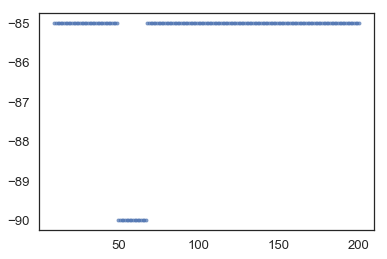

In [17]:
plot(entry_speeds, optimal_angles, '.')

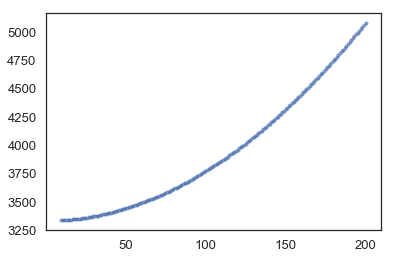

In [18]:
plot(entry_speeds, optimal_thrusts, '.')

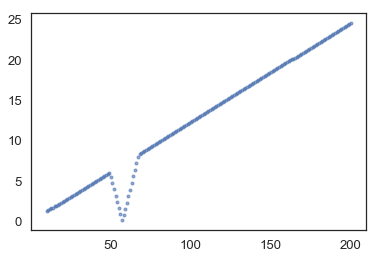

In [19]:
plot(entry_speeds, optimal_speeds, '.')

In [20]:
sample_s = 88
angles = [a for a in data[sample_s]]
thrust = [data[sample_s][a]['optimal_thrust'] for a in angles]
speed = [data[sample_s][a]['impact_speed'] for a in angles]
time = [data[sample_s][a]['time'] for a in angles];

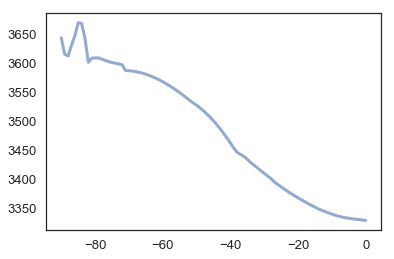

In [21]:
plot(angles, thrust)

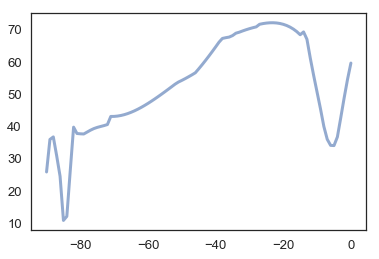

In [22]:
plot(angles, speed)

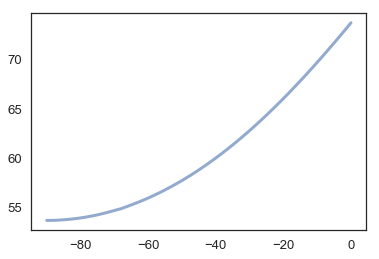

In [23]:
plot(angles, time)

In [24]:
def optimize_for_fuel(angle_data, threshold):
    """Selects the entry angle and thrust that will minimize fuel usage
    while still landing the rover safely.
    
    angle_data: Dictionary object containing the optimum thrust, landing speed, 
    and descent time for every entry angle between 0 and -90 degrees for a specific
    entry speed
    threshold: maximum impact speed at which the rover can land safely
    
    returns: Dictionary object includes
     - angle: optimal angle in degrees
     - thrust: optimal thrust in kg * m/s^2
     - impact_speed: landing speed in m/s
     - time: descent time in s
    """
    
    safe_entries = {a: d for a,d in angle_data.items() if d['impact_speed'] <= threshold}
    if not safe_entries: return None
    
    s_e = safe_entries
    least_fuel = min(s_e, key=lambda a: s_e[a]['optimal_thrust'] * s_e[a]['time'])
    efficient_entry = {
        'angle': least_fuel,
        'thrust': s_e[least_fuel]['optimal_thrust'],
        'impact_speed': s_e[least_fuel]['impact_speed'],
        'time': s_e[least_fuel]['time']
    }
    
    return efficient_entry

In [25]:
def fuel_optimized(data_dict, threshold):
    """Determines the most fuel efficient entry angle and thrust that
    will still land the rover safely (if possible) for every given entry speed.
    
    data_dict: Dictionary object containing the optimum thrust, landing speed, 
    and descent time for every entry angle between 0 and -90 degrees for each 
    entry speed
    threshold: maximum impact speed at which the rover can land safely
    
    returns: Dictionary object containing the most fuel efficient entry angle,
    thrust, landing speed, and descent time for every entry speed where a safe 
    landing is possible
    """
    
    efficient_entries = {}
    
    for entry_speed in data_dict:
        fuel_optimized_entry = optimize_for_fuel(data_dict[entry_speed], threshold)
        if fuel_optimized_entry is not None:
            efficient_entries[entry_speed] = fuel_optimized_entry
    
    return efficient_entries

In [26]:
max_safe_impact_speed = 14
fuel_optimized_data = fuel_optimized(data, max_safe_impact_speed)

fuel_entry_speeds = [s for s in fuel_optimized_data]
fuel_angles = [fuel_optimized_data[s]['angle'] for s in fuel_optimized_data]
fuel_thrusts = [fuel_optimized_data[s]['thrust'] for s in fuel_optimized_data]
fuel_times = [fuel_optimized_data[s]['time'] for s in fuel_optimized_data];

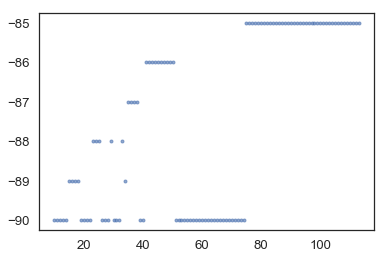

In [27]:
plot(fuel_entry_speeds, fuel_angles, '.')

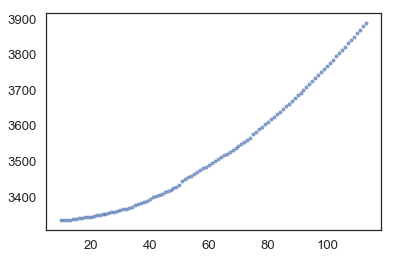

In [28]:
plot(fuel_entry_speeds, fuel_thrusts, '.')

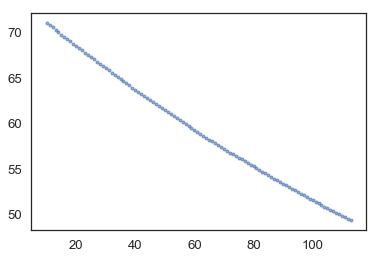

In [29]:
plot(fuel_entry_speeds, fuel_times, '.')